In [1]:
pip install skforecast

In [2]:
pip install skforecast==0.10.1

In [3]:
pip install git+https://github.com/JoaquinAmatRodrigo/skforecast#master

  Cloning https://github.com/JoaquinAmatRodrigo/skforecast to /tmp/pip-req-build-tijk9gbl
  Running command git clone --filter=blob:none --quiet https://github.com/JoaquinAmatRodrigo/skforecast /tmp/pip-req-build-tijk9gbl
  Resolved https://github.com/JoaquinAmatRodrigo/skforecast to commit db04f762d878c096b87b97de1a20f35025bbc437
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
pip install skforecast[full]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.2 MB/s eta 0:00:00


In [5]:
pip install skforecast[sarimax]

In [6]:
pip install skforecast[plotting]

In [7]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plt.style.use('seaborn-v0_8-darkgrid')

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('once')

In [8]:
datos = pd.read_csv('raw.githubusercontent.com_JoaquinAmatRodrigo_skforecast_master_data_vic_elec.csv')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52608 entries, 0 to 52607
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         52608 non-null  object 
 1   Demand       52608 non-null  float64
 2   Temperature  52608 non-null  float64
 3   Date         52608 non-null  object 
 4   Holiday      52608 non-null  bool   
dtypes: bool(1), float64(2), object(2)
memory usage: 1.7+ MB


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [9]:
# Conversión del formato fecha
# ==============================================================================
datos['Time'] = pd.to_datetime(datos['Time'], format='%Y-%m-%dT%H:%M:%SZ')
datos = datos.set_index('Time')
datos = datos.asfreq('30min')
datos = datos.sort_index()
datos.head(2)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True


In [10]:
# Verificar que un índice temporal está completo
# ==============================================================================
(datos.index == pd.date_range(start=datos.index.min(),
                              end=datos.index.max(),
                              freq=datos.index.freq)).all()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


True

In [11]:
print(f"Filas con missing values: {datos.isnull().any(axis=1).mean()}")


Filas con missing values: 0.0


In [12]:
# Completar huecos en un índice temporal
# ==============================================================================
datos.asfreq(freq='30min', fill_value=np.nan)

,Demand,Temperature,Date,Holiday
Time,,,,
2011-12-31 13:00:00,4382.825174,21.40,2012-01-01,True
2011-12-31 13:30:00,4263.365526,21.05,2012-01-01,True
2011-12-31 14:00:00,4048.966046,20.70,2012-01-01,True
2011-12-31 14:30:00,3877.563330,20.55,2012-01-01,True
2011-12-31 15:00:00,4036.229746,20.40,2012-01-01,True
...,...,...,...,...
2014-12-31 10:30:00,3873.448714,19.00,2014-12-31,False
2014-12-31 11:00:00,3791.637322,18.50,2014-12-31,False
2014-12-31 11:30:00,3724.835666,17.70,2014-12-31,False


In [13]:
# Agregado en intervalos de 1H
# ==============================================================================
# Se elimina la columna Date para que no genere error al agregar. La columna Holiday
# no genera error ya que es booleana y se trata como 0-1.
datos = datos.drop(columns='Date')
datos = datos.resample(rule='H', closed='left', label ='right').mean()
datos

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Demand,Temperature,Holiday
Time,,,
2011-12-31 14:00:00,4323.095350,21.225,1.0
2011-12-31 15:00:00,3963.264688,20.625,1.0
2011-12-31 16:00:00,3950.913495,20.325,1.0
2011-12-31 17:00:00,3627.860675,19.850,1.0
2011-12-31 18:00:00,3396.251676,19.025,1.0
...,...,...,...
2014-12-31 09:00:00,4069.625550,21.600,0.0
2014-12-31 10:00:00,3909.230704,20.300,0.0
2014-12-31 11:00:00,3900.600901,19.650,0.0


In [14]:
# Separación datos train-val-test
# ==============================================================================
datos = datos.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00'].copy()
fin_train = '2013-12-31 23:59:00'
fin_validacion = '2014-11-30 23:59:00'
datos_train = datos.loc[: fin_train, :].copy()
datos_val   = datos.loc[fin_train:fin_validacion, :].copy()
datos_test  = datos.loc[fin_validacion:, :].copy()

print(f"Fechas train      : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas validacion : {datos_val.index.min()} --- {datos_val.index.max()}  (n={len(datos_val)})")
print(f"Fechas test       : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Fechas train      : 2012-01-01 00:00:00 --- 2013-12-31 23:00:00  (n=17544)
Fechas validacion : 2014-01-01 00:00:00 --- 2014-11-30 23:00:00  (n=8016)
Fechas test       : 2014-12-01 00:00:00 --- 2014-12-30 23:00:00  (n=720)


<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

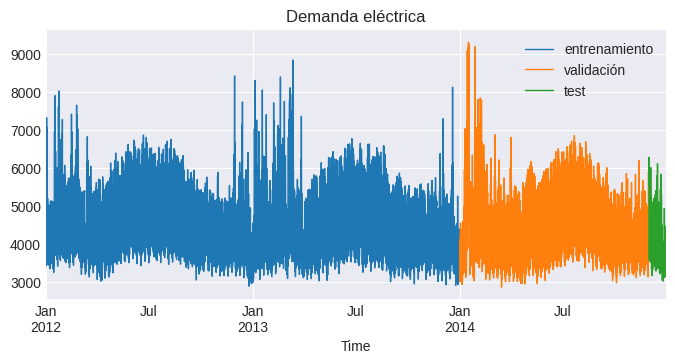

In [15]:
# Gráfico serie temporal
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos_train.Demand.plot(ax=ax, label='entrenamiento', linewidth=1)
datos_val.Demand.plot(ax=ax, label='validación', linewidth=1)
datos_test.Demand.plot(ax=ax, label='test', linewidth=1)
ax.set_title('Demanda eléctrica')
ax.legend();

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


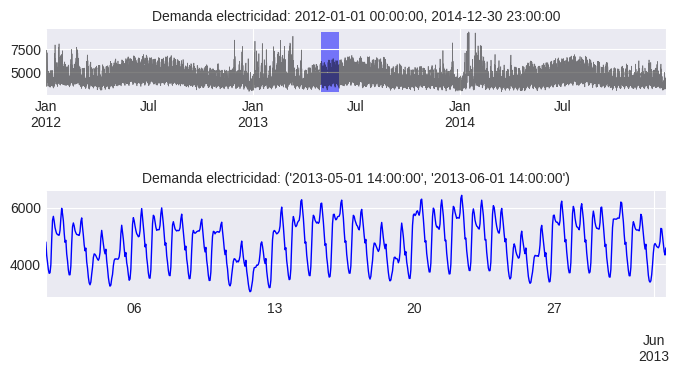

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [16]:
# Gráfico serie temporal con zoom
# ==============================================================================
zoom = ('2013-05-01 14:00:00','2013-06-01 14:00:00')
fig = plt.figure(figsize=(8, 4))
grid = plt.GridSpec(nrows=8, ncols=1, hspace=0.6, wspace=0)
main_ax = fig.add_subplot(grid[1:3, :])
zoom_ax = fig.add_subplot(grid[5:, :])
datos.Demand.plot(ax=main_ax, c='black', alpha=0.5, linewidth=0.5)
min_y = min(datos.Demand)
max_y = max(datos.Demand)
main_ax.fill_between(zoom, min_y, max_y, facecolor='blue', alpha=0.5, zorder=0)
main_ax.set_xlabel('')
datos.loc[zoom[0]: zoom[1]].Demand.plot(ax=zoom_ax, color='blue', linewidth=1)
main_ax.set_title(f'Demanda electricidad: {datos.index.min()}, {datos.index.max()}', fontsize=10)
zoom_ax.set_title(f'Demanda electricidad: {zoom}', fontsize=10)
zoom_ax.set_xlabel('')
plt.subplots_adjust(hspace=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


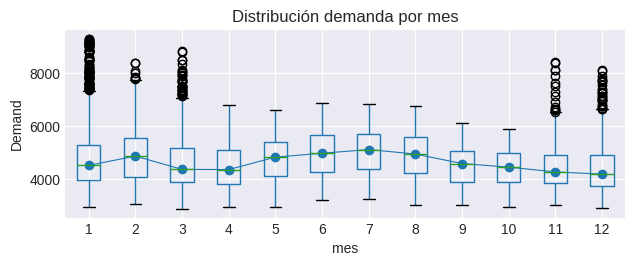

In [17]:
# Gráfico boxplot para estacionalidad anual
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['mes'] = datos.index.month
datos.boxplot(column='Demand', by='mes', ax=ax,)
datos.groupby('mes')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por mes')
fig.suptitle('');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


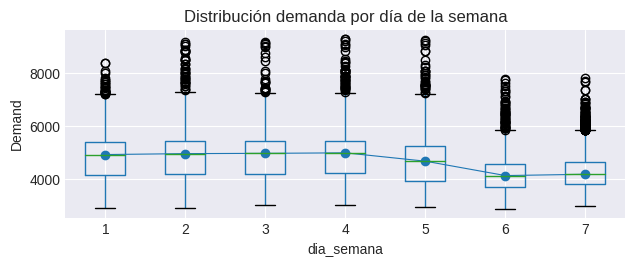

In [18]:
# Gráfico boxplot para estacionalidad semanal
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['dia_semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Demand', by='dia_semana', ax=ax)
datos.groupby('dia_semana')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por día de la semana')
fig.suptitle('');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


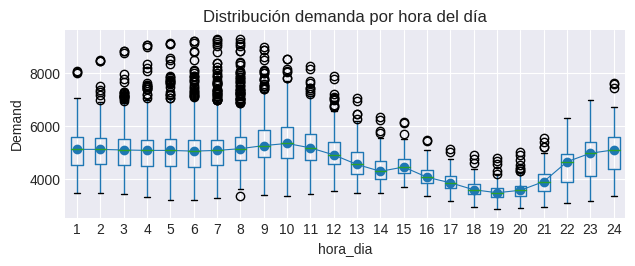

In [19]:
# Gráfico boxplot para estacionalidad diaria
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 2.5))
datos['hora_dia'] = datos.index.hour + 1
datos.boxplot(column='Demand', by='hora_dia', ax=ax)
datos.groupby('hora_dia')['Demand'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demand')
ax.set_title('Distribución demanda por hora del día')
fig.suptitle('');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


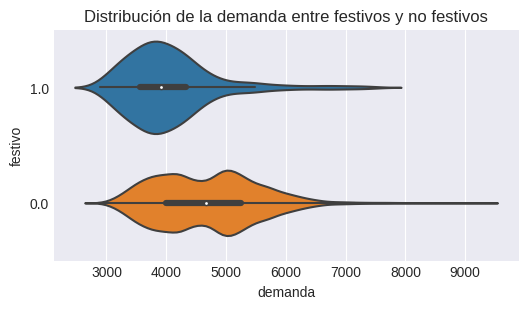

In [20]:
# Grafico violinplot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 3))
sns.violinplot(
    x       = 'Demand',
    y       = 'Holiday',
    data    = datos.assign(Holiday = datos.Holiday.astype(str)),
    palette = 'tab10',
    ax      = ax
)
ax.set_title('Distribución de la demanda entre festivos y no festivos')
ax.set_xlabel('demanda')
ax.set_ylabel('festivo');

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


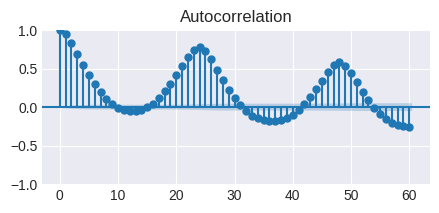

In [21]:
# Gráfico autocorrelación
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_acf(datos.Demand, ax=ax, lags=60)
plt.show()

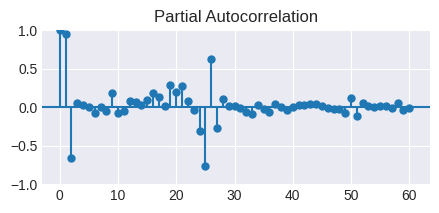

In [22]:
# Gráfico autocorrelación parcial
# ==============================================================================
fig, ax = plt.subplots(figsize=(5, 2))
plot_pacf(datos.Demand, ax=ax, lags=60)
plt.show()

In [23]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 24,
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


ForecasterAutoreg 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 24 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-25 23:48:57 
Last fit date: 2023-10-25 23:48:57 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [24]:
# Backtest
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['Demand'],
                            steps              = 24,
                            metric             = 'mean_absolute_error',
                            initial_train_size = len(datos.loc[:fin_validacion]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = True,
                            show_progress      = True
                        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 25560
Number of observations used for backtesting: 720
    Number of folds: 30
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-01 00:00:00 -- 2014-12-01 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-11-30 23:00:00  (n=25560)
    Validation: 2014-12-05

  0%|          | 0/30 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


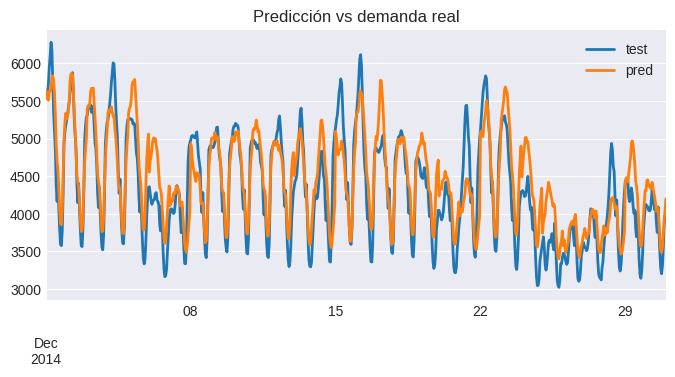

In [25]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(ax=ax, linewidth=2, label='test')
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [26]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 289.5191331582498


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
# Grid search de hiperparámetros
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(),
                 lags          = 24, # Este valor será remplazado en el grid search
                 transformer_y = StandardScaler()
             )

# Lags utilizados como predictores
lags_grid = [5, 24, [1, 2, 3, 23, 24, 25, 47, 48, 49]]

# Hiperparámetros del regresor
param_grid = {'alpha': np.logspace(-3, 5, 10)}

resultados_grid = grid_search_forecaster(
                      forecaster         = forecaster,
                      y                  = datos.loc[:fin_validacion, 'Demand'],
                      steps              = 24,
                      metric             = 'mean_absolute_error',
                      param_grid         = param_grid,
                      lags_grid          = lags_grid,
                      initial_train_size = len(datos[:fin_train]),
                      refit              = False,
                      n_jobs             = 'auto',
                      return_best        = True,
                      verbose            = False
                  )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3 23 24 25 47 48 49] 
  Parameters: {'alpha': 215.44346900318823}
  Backtesting metric: 257.84309845082885



In [28]:
# Resultados Grid Search
# ==============================================================================
resultados_grid

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,lags,params,mean_absolute_error,alpha
26,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 215.44346900318823},257.843098,215.443469
25,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 27.825594022071257},290.527024,27.825594
24,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 3.593813663804626},306.626903,3.593814
23,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.46415888336127775},309.392653,0.464159
22,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.05994842503189409},309.775993,0.059948
21,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.007742636826811269},309.825950,0.007743
20,"[1, 2, 3, 23, 24, 25, 47, 48, 49]",{'alpha': 0.001},309.832409,0.001000
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.001},325.041130,0.001000
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.007742636826811269},325.043580,0.007743
12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",{'alpha': 0.05994842503189409},325.062545,0.059948


In [29]:
forecaster


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ForecasterAutoreg 
Regressor: Ridge(alpha=215.44346900318823) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44346900318823, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-25 23:49:01 
Last fit date: 2023-10-25 23:50:38 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

  0%|          | 0/30 [00:00<?, ?it/s]

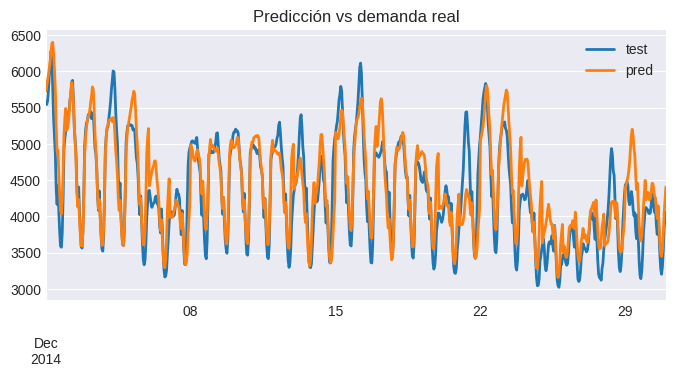

In [30]:
# Backtest modelo final
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['Demand'],
                            steps              = 24,
                            metric             = mean_absolute_error,
                            initial_train_size = len(datos[:fin_validacion]),
                            refit              = False,
                            n_jobs             = 'auto',
                            verbose            = False,
                            show_progress      = True
                        )

fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [31]:
# Error backtest
# ==============================================================================
print(f'Error backtest: {metrica}')

Error backtest: 251.92726486972396


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# Backtest del conjunto de test con intervalos de predicción
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster          = forecaster,
                            y                   = datos['Demand'],
                            steps               = 24,
                            metric              = 'mean_absolute_error',
                            initial_train_size  = len(datos.loc[:fin_validacion]),
                            refit               = False,
                            interval            = [10, 90],
                            n_boot              = 500,
                            in_sample_residuals = True,
                            n_jobs              = 'auto',
                            verbose             = False,
                            show_progress       = True
                        )

print('Métrica backtesting:', metrica)
predicciones.head(5)

  0%|          | 0/30 [00:00<?, ?it/s]

Métrica backtesting: 251.92726486972396


,pred,lower_bound,upper_bound
2014-12-01 00:00:00,5727.844947,5598.931844,5849.598860
2014-12-01 01:00:00,5802.807448,5599.126464,5974.887546
2014-12-01 02:00:00,5879.948808,5619.868497,6113.714851
2014-12-01 03:00:00,5953.414468,5657.436246,6239.937101
2014-12-01 04:00:00,6048.594433,5697.672143,6342.846047


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


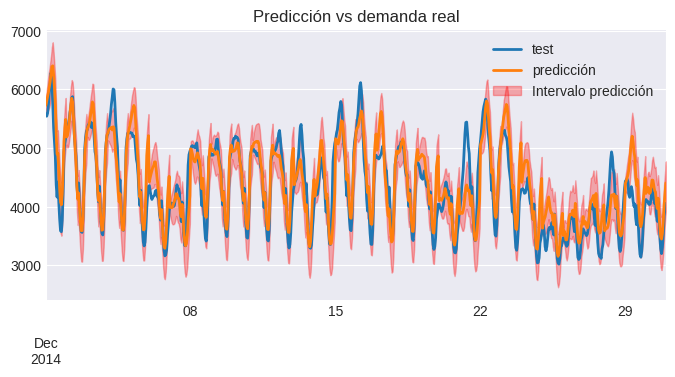

In [33]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones['pred'].plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    alpha = 0.3,
    color = 'red',
    label = 'Intervalo predicción'
)
ax.legend();

In [34]:
# Cobertura del intervalo predicho
# ==============================================================================
dentro_intervalo = np.where(
                       (datos.loc[fin_validacion:, 'Demand'] >= predicciones['lower_bound']) & \
                       (datos.loc[fin_validacion:, 'Demand'] <= predicciones['upper_bound']),
                       True,
                       False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

Cobertura del intervalo predicho: 79.03 %


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
# Final de initial_train_size + 12 posiciones
# ==============================================================================
datos.iloc[:len(datos.loc[:fin_validacion])+12].tail(2)

,Demand,Temperature,Holiday,mes,dia_semana,hora_dia
Time,,,,,,
2014-12-01 10:00:00,5084.011257,19.90,0.0,12,1,11
2014-12-01 11:00:00,4851.066658,19.35,0.0,12,1,12


In [36]:
# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            n_jobs                = 'auto',
                            verbose               = True,
                            show_progress         = True
                        )

print("")
print('Métrica backtesting:', metrica)
predicciones.head(5)

Information of backtesting process
----------------------------------
Number of observations used for initial training: 25572
Number of observations used for backtesting: 708
    Number of folds: 29
    Number of steps per fold: 24
    Number of steps to exclude from the end of each train set before test (gap): 12

Fold: 0
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-02 00:00:00 -- 2014-12-02 23:00:00  (n=24)
Fold: 1
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-03 00:00:00 -- 2014-12-03 23:00:00  (n=24)
Fold: 2
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-04 00:00:00 -- 2014-12-04 23:00:00  (n=24)
Fold: 3
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-05 00:00:00 -- 2014-12-05 23:00:00  (n=24)
Fold: 4
    Training:   2012-01-01 00:00:00 -- 2014-12-01 11:00:00  (n=25572)
    Validation: 2014-12-0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/29 [00:00<?, ?it/s]


Métrica backtesting: 374.33731759267727


,pred
2014-12-02 00:00:00,5154.952086
2014-12-02 01:00:00,5183.487126
2014-12-02 02:00:00,5263.237055
2014-12-02 03:00:00,5397.278836
2014-12-02 04:00:00,5571.542647


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


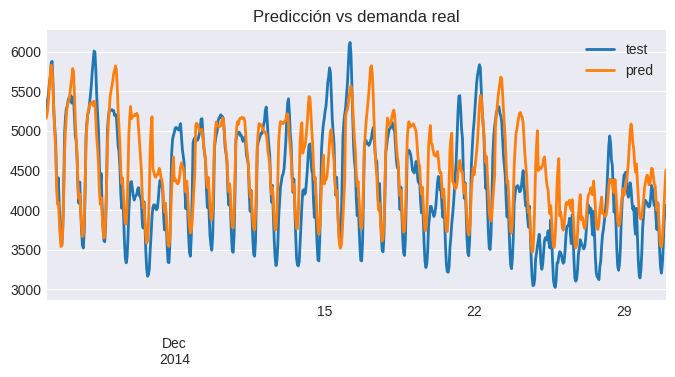

In [37]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [38]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 374.33731759267727


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
# Importancia predictores
# ==============================================================================
forecaster.get_feature_importances()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,feature,importance
0,lag_1,1.027185
1,lag_2,-0.017558
2,lag_3,-0.072357
3,lag_23,0.145979
4,lag_24,0.351853
5,lag_25,-0.471072
6,lag_47,-0.057676
7,lag_48,0.284220
8,lag_49,-0.217552


In [40]:
# Se convierte la columna Holiday de boolean a integer
# ==============================================================================
datos['Holiday'] = datos['Holiday'].astype(int)
datos_train['Holiday'] = datos_train['Holiday'].astype(int)
datos_test['Holiday'] = datos_test['Holiday'].astype(int)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor     = Ridge(alpha=215.44, random_state=123),
                 lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                 transformer_y = StandardScaler()
             )

forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'], exog=datos.loc[:fin_validacion, 'Holiday'])
forecaster

ForecasterAutoreg 
Regressor: Ridge(alpha=215.44, random_state=123) 
Lags: [ 1  2  3 23 24 25 47 48 49] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Window size: 49 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Holiday 
Training range: [Timestamp('2012-01-01 00:00:00'), Timestamp('2014-11-30 23:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: H 
Regressor parameters: {'alpha': 215.44, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2023-10-25 23:52:07 
Last fit date: 2023-10-25 23:52:07 
Skforecast version: 0.10.1 
Python version: 3.10.12 
Forecaster id: None 

In [42]:
# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            exog                  = datos['Holiday'],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True
                        )

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/29 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


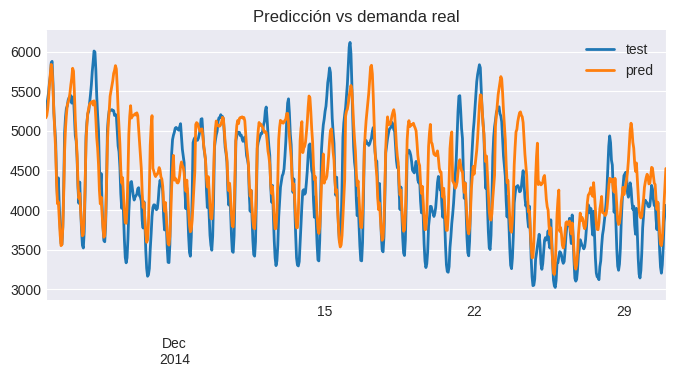

In [43]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(8, 3.5))
datos.loc[predicciones.index, 'Demand'].plot(linewidth=2, label='test', ax=ax)
predicciones.plot(linewidth=2, label='predicción', ax=ax)
ax.set_title('Predicción vs demanda real')
ax.legend();

In [44]:
# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print(f"Error de backtest: {error}")

Error de backtest: 359.10771907713166


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [45]:
# Creación de nuevas variables exógenas
# ==============================================================================
# Al ser datos  horarios y empezar a las 00:00 se tienen que desplazar los valores
# de 24 en 24.
datos['Holiday_day_before'] = datos['Holiday'].shift(24)
datos['Holiday_next_day']   = datos['Holiday'].shift(-24)
datos = datos.dropna()

# One hot encoding del día de la semana y la hora del día
# ==============================================================================
one_hot_encoder = make_column_transformer(
                      (
                          OneHotEncoder(sparse_output=False, drop='if_binary'),
                          ['dia_semana', 'hora_dia'],
                      ),
                      remainder="passthrough",
                      verbose_feature_names_out=False,
                  ).set_output(transform="pandas")

datos = one_hot_encoder.fit_transform(datos)
datos.head(3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6,dia_semana_7,hora_dia_1,hora_dia_2,hora_dia_3,...,hora_dia_21,hora_dia_22,hora_dia_23,hora_dia_24,Demand,Temperature,Holiday,mes,Holiday_day_before,Holiday_next_day
Time,,,,,,,,,,,,,,,,,,,,,
2012-01-02 00:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,5262.895338,32.825,1,1,1.0,0.0
2012-01-02 01:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,5786.043417,34.500,1,1,1.0,0.0
2012-01-02 02:00:00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,6236.144167,36.725,1,1,1.0,0.0


In [46]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor     = Ridge(alpha=215.44, random_state=123),
                lags          = [1, 2, 3, 23, 24, 25, 47, 48, 49],
                transformer_y = StandardScaler()
             )

exog = [column for column in datos.columns if column.startswith(('dia', 'hora', 'Holiday'))]
forecaster.fit(y=datos.loc[:fin_validacion, 'Demand'], exog=datos.loc[:fin_validacion, exog])

# Backtesting con gap
# ==============================================================================
metrica, predicciones = backtesting_forecaster(
                            forecaster            = forecaster,
                            y                     = datos['Demand'],
                            exog                  = datos[exog],
                            steps                 = 24,
                            metric                = 'mean_absolute_error',
                            initial_train_size    = len(datos.loc[:fin_validacion])+12,
                            gap                   = 12,
                            allow_incomplete_fold = True,
                            refit                 = False,
                            n_jobs                = 'auto',
                            verbose               = False,
                            show_progress         = True
                        )

# Error backtest
# ==============================================================================
error = mean_absolute_error(
            y_true = datos.loc[predicciones.index, 'Demand'],
            y_pred = predicciones
        )

print("")
print(f"Error de backtest: {error}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/28 [00:00<?, ?it/s]


Error de backtest: 298.61178509202466
